In [ ]:
#here we test all the components.

In [9]:
'''
second performance test
'''
%time
import sys
sys.path.append('..')
%matplotlib inline
# you might need this:
#import matplotlib
#matplotlib.use('Agg')

from eden.converter.graph.gspan import gspan_to_eden
from graphlearn.graphlearn import GraphLearnSampler
import itertools
from eden.graph import Vectorizer
import matplotlib.pyplot as plt

from eden.util import fit_estimator,fit , random_bipartition_iter,estimate
import random
from eden.util import selection_iterator as picker
from sklearn.linear_model import SGDClassifier

vect=Vectorizer(complexity = 3)
#2401 positives and 1936 negatives
NUMPOS=2401
NUMNEG=1936

######################## testing ##############################

def train_estimator_and_evaluate_testsets(pos_original,neg_original,pos_augmented,neg_augmented,test_pos,test_neg):

    # create graph sets...orig augmented and sampled
    pos_orig,pos_orig_ = itertools.tee(pos_original,2)
    neg_orig,neg_orig_ = itertools.tee(neg_original,2)
    
    pos_augmented , pos_sampled = itertools.tee(pos_augmented)
    neg_augmented , neg_sampled = itertools.tee(neg_augmented)
    
    pos_augmented = itertools.chain(pos_augmented,pos_orig_)
    neg_augmented = itertools.chain(neg_augmented,neg_orig_)

    res=[]
    for (iterpos,iterneg) in [(pos_orig, neg_orig),( pos_augmented, neg_augmented),(pos_sampled,neg_sampled)]:
        test_pos,p=itertools.tee(test_pos)
        test_neg,n=itertools.tee(test_neg)
      
        res.append(estimate(p,n,fit(iterpos,iterneg,vect,n_jobs=-1),vect)[1])
    return res


############ sampelr ###########
def unpack(graphs):
    for graphlist in graphs:
        yield graphlist[0]

def sample(graphs):
    
    sampler =GraphLearnSampler()
    graphs, graphs_ = itertools.tee(graphs)
    sampler.fit(graphs)
    return sampler.sample(graphs_,
                        same_radius=False,
                        same_core_size=False,
                        sampling_interval=9999,
                        select_cip_max_tries=100,
                        batch_size=30,
                        n_steps=100,
                        n_jobs=-1,
                        annealing_factor=0.9
                        )




CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.82 µs
evaluating..
Test set
Instances: 4033 ; Features: 1048577 with an avg of 180 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.71      0.73      0.72      1800
          1       0.78      0.76      0.77      2233

avg / total       0.75      0.75      0.75      4033

APR: 0.840
ROC: 0.820
Test set
Instances: 4033 ; Features: 1048577 with an avg of 180 features per instance
--------------------------------------------------------------------------------
Test Estimate
             precision    recall  f1-score   support

         -1       0.71      0.72      0.72      1800
          1       0.77      0.77      0.77      2233

avg / total       0.75      0.75      0.75      4033

APR: 0.839
ROC: 0.821
Test set
Instances: 4033 ; Features: 1048577 with an avg of 180 features per instance
-

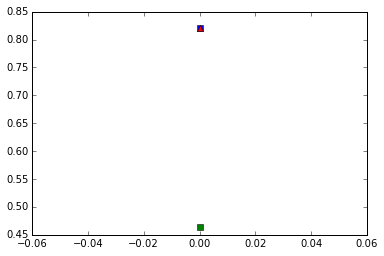

In [10]:
%time

# initializing 
graphs_pos= gspan_to_eden('bursi.pos.gspan')
graphs_neg= gspan_to_eden('bursi.neg.gspan')
originals=[]
improved=[]
only_new=[]

percentages=[.2,.4,.6,.8,1]
percentages=[.1]

for perc in percentages:

    ######### first we generate all the iterators ###########
    # copy the mega set
    graphs_pos, graphs_pos_ = itertools.tee(graphs_pos,2)
    graphs_neg, graphs_neg_ = itertools.tee(graphs_neg,2)


    # use shuffled list to create test and sample set
    pos,pos_test = random_bipartition_iter(graphs_pos_,0.7*perc)
    pos,pos_= itertools.tee(pos)
    neg,neg_test = random_bipartition_iter(graphs_neg_,0.7*perc)
    neg,neg_= itertools.tee(neg)
 
    ############### then we sample #####################
    sampled_neg= unpack(sample(neg))
    sampled_pos= unpack(sample(pos))
    
    
    ######### and last we evaluate ###########
    print 'evaluating..'
    aug,ori,new=train_estimator_and_evaluate_testsets( pos_,neg_,sampled_pos, sampled_neg, pos_test,neg_test)
    improved.append(aug)
    originals.append(ori)
    only_new.append(new)
    print "done:"+str(perc)
    print "*"*80

print improved
print originals
print only_new
# draw 
t = range(len(percentages))
plt.plot(t,originals ,'bs')
plt.plot(t, improved ,'r^')
plt.plot(t, only_new ,'gs')
plt.savefig('zomg2.png')
